# Filters

## L-tap filter
FIR-Filter (so settles to zero in finite time). Contains a bunch of coefficients (L-numerical values).
- L: number of "taps" (coefficients - discrete time samples used for filtering)

$$y[n] = \sum_{k=0}^{L-1} h[k] x[n-k] = h[0]x[n] + h[1]x[n-1] + h[2]x[n-2] + \cdots + h[L-1]x[n-L+1]$$
- y[n] output at time n
- x[n] input at time n
- h[k] L-filter coefficients
- L: number of taps

In [ ]:
import numpy as np
from scipy.signal import firwin2, freqz
import matplotlib.pyplot as plt


def design_fir_from_freq_response(L, h_f, fs=1.0, num_freq_samples=512, window='hann'):
    """
    Design an L-tap FIR filter from a desired frequency response h_f.

    Parameters:
    -----------
    L : int
        Number of filter taps.
    h_f : callable or array-like
        If callable, h_f(f) returns desired magnitude at frequency f (in Hz).
        If array-like, interpreted as desired magnitude on the frequency grid.
    fs : float
        Sampling frequency in Hz. Defaults to 1.0 (normalized).
    num_freq_samples : int
        Number of frequency samples used in design. Defaults to 512.
    window : str or tuple
        Window type to apply (passed to firwin2). Defaults to 'hann'.

    Returns:
    --------
    taps : ndarray
        Array of length L containing the FIR filter coefficients.
    """
    # Define the frequency grid from 0 to Nyquist (fs/2)
    f = np.linspace(0, fs / 2, num_freq_samples)

    # Evaluate desired magnitude response
    if callable(h_f):
        h_vals = np.array([h_f(fi) for fi in f])
    else:
        h_vals = np.array(h_f)
        if len(h_vals) != num_freq_samples:
            raise ValueError("Length of h_f array must match num_freq_samples")

    # Normalize frequencies to [0, 1] for firwin2 (1 corresponds to Nyquist)
    f_norm = f / (fs / 2)

    # Design the filter taps
    taps = firwin2(L, f_norm, h_vals, window=window)

    return taps

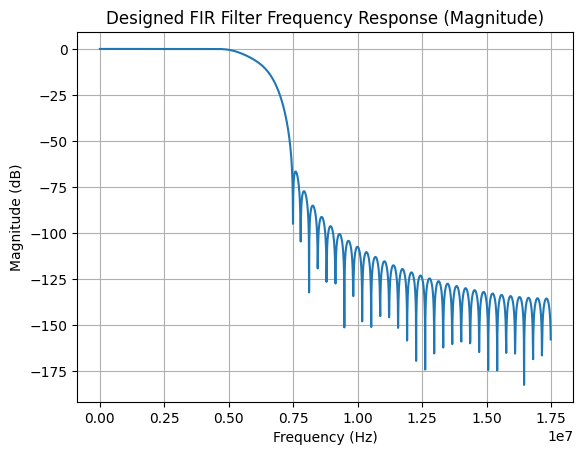

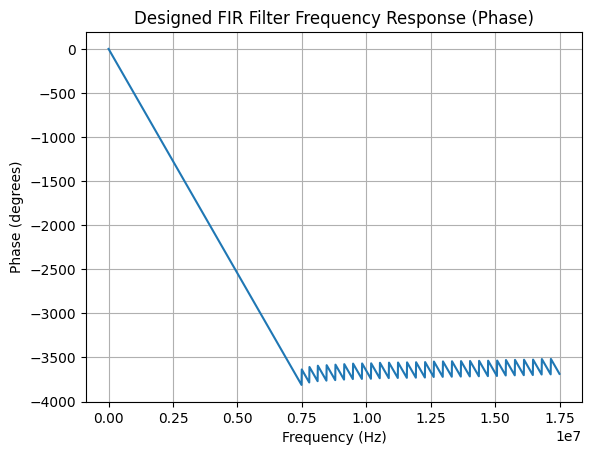

In [10]:
import numpy as np
from scipy.signal import firwin2, freqz
import matplotlib.pyplot as plt

# Re-design the filter taps (same as before)
fs = 35e6       # Sampling rate
L = 100          # Number of taps

# Desired frequency response function
def h_desired(f):
    if f <= 5e6:
        return 1.0
    elif f >= 7e6:
        return 0.0
    else:
        return (7e6 - f) / (7e6 - 5e6)

# Build frequency grid and desired magnitudes
num_freq_samples = 1024
f = np.linspace(0, fs/2, num_freq_samples)
h_vals = np.array([h_desired(fi) for fi in f])
f_norm = f / (fs/2)

# Design taps
taps = firwin2(L, f_norm, h_vals, window='hann')

# Compute frequency response
w, h = freqz(taps, worN=2048, fs=fs)

# Plot magnitude response
plt.figure()
plt.plot(w, 20 * np.log10(np.abs(h)))
plt.title("Designed FIR Filter Frequency Response (Magnitude)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.grid(True)

# Plot phase response
plt.figure()
plt.plot(w, np.unwrap(np.angle(h)) * 180 / np.pi)
plt.title("Designed FIR Filter Frequency Response (Phase)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Phase (degrees)")
plt.grid(True)

plt.show()

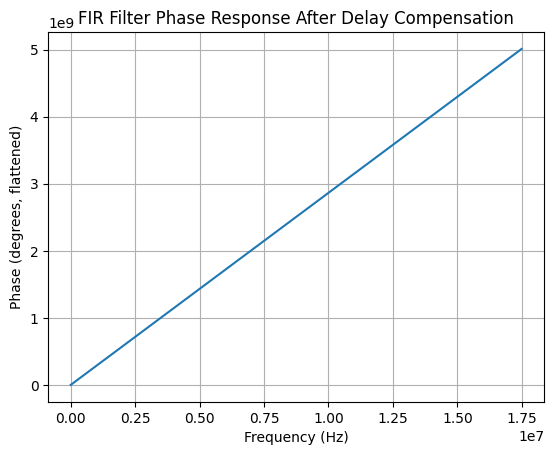

In [11]:
import numpy as np
from scipy.signal import firwin2, freqz
import matplotlib.pyplot as plt

# Re-design the filter taps (same as before)
fs = 35e6       # Sampling rate
L = 11          # Number of taps

# Desired frequency response function
def h_desired(f):
    if f <= 5e6:
        return 1.0
    elif f >= 7e6:
        return 0.0
    else:
        return (7e6 - f) / (7e6 - 5e6)

# Build frequency grid and desired magnitudes
num_freq_samples = 1024
f = np.linspace(0, fs/2, num_freq_samples)
h_vals = np.array([h_desired(fi) for fi in f])
f_norm = f / (fs/2)

# Design taps
taps = firwin2(L, f_norm, h_vals, window='hann')

# Compute frequency response
w, h = freqz(taps, worN=2048, fs=fs)

# Calculate original phase (radians)
phi = np.unwrap(np.angle(h))

# Compensate for the filter's group delay ((L-1)/2 samples)
group_delay = (L - 1) / 2
phi_flat = phi + w * group_delay

# Convert to degrees
phi_flat_deg = phi_flat * 180 / np.pi

# Plot compensated phase response
plt.figure()
plt.plot(w, phi_flat_deg)
plt.title("FIR Filter Phase Response After Delay Compensation")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Phase (degrees, flattened)")
plt.grid(True)
plt.show()

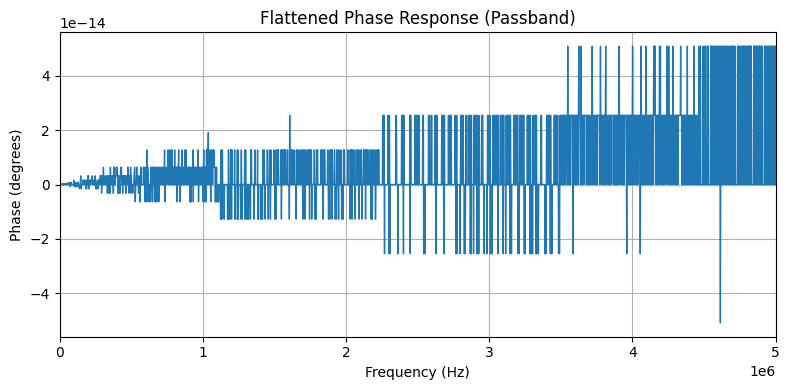

Within the passband (0–5 MHz), the residual phase shift ranges from -5.09e-14° to 5.09e-14°.


In [12]:
import numpy as np
from scipy.signal import firwin2, freqz
import matplotlib.pyplot as plt

# Filter specs
fs = 35e6
L = 11

# Desired mag response
def h_desired(f):
    if f <= 5e6:
        return 1.0
    elif f >= 7e6:
        return 0.0
    else:
        return (7e6 - f) / (7e6 - 5e6)

# Build frequency grid
num_freq_samples = 1024
f = np.linspace(0, fs/2, num_freq_samples)
h_vals = np.array([h_desired(fi) for fi in f])
f_norm = f / (fs/2)

# Design taps
taps = firwin2(L, f_norm, h_vals, window='hann')

# Compute frequency response (w in rad/sample)
w, h = freqz(taps, worN=8192)
# Unwrapped phase
phi = np.unwrap(np.angle(h))
# Group delay compensation
group_delay = (L - 1) / 2
phi_flat = phi + w * group_delay
# Convert to degrees
phi_flat_deg = np.degrees(phi_flat)
# Convert w to Hz for x-axis
freqs = w / (2*np.pi) * fs

# Extract passband region (f <= 5 MHz)
passband_mask = freqs <= 5e6
residual = phi_flat_deg[passband_mask]
min_res, max_res = residual.min(), residual.max()

# Plot flattened phase
plt.figure(figsize=(8, 4))
plt.plot(freqs, phi_flat_deg, linewidth=1)
plt.xlim(0, 5e6)
plt.ylim(min_res*1.1, max_res*1.1)
plt.title("Flattened Phase Response (Passband)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Phase (degrees)")
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Within the passband (0–5 MHz), the residual phase shift ranges from {min_res:.2e}° to {max_res:.2e}°.")

